In [23]:
import sys
import os
sys.path.append(os.path.abspath("../scripts"))

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import joblib
from utils import inverse_transform
from sklearn.metrics import mean_squared_error, mean_absolute_error

# LSTM 모델 클래스 (학습 시와 동일하게 정의)
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=96, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.view(-1)

# 데이터 로드
X = np.load("../data/processed/X_lstm.npy").astype(np.float32)
y = np.load("../data/processed/y_lstm.npy").astype(np.float32)

# 학습에 사용한 스케일러 불러오기
scaler = joblib.load("models/standard_scaler.pkl")


LSTM Prediction Evaluation
RMSE: 2.31358
MAE : 0.91821
y_true[:5] = [1.79999999 1.9        1.30000003 1.20000002 1.1       ]
y_pred_inv[:5] = [1.71142036 1.72678883 1.77687704 1.52717514 1.39067984]
std(y_pred) = 1.1847321
std(y_pred_inv) = 2.4071978907274523


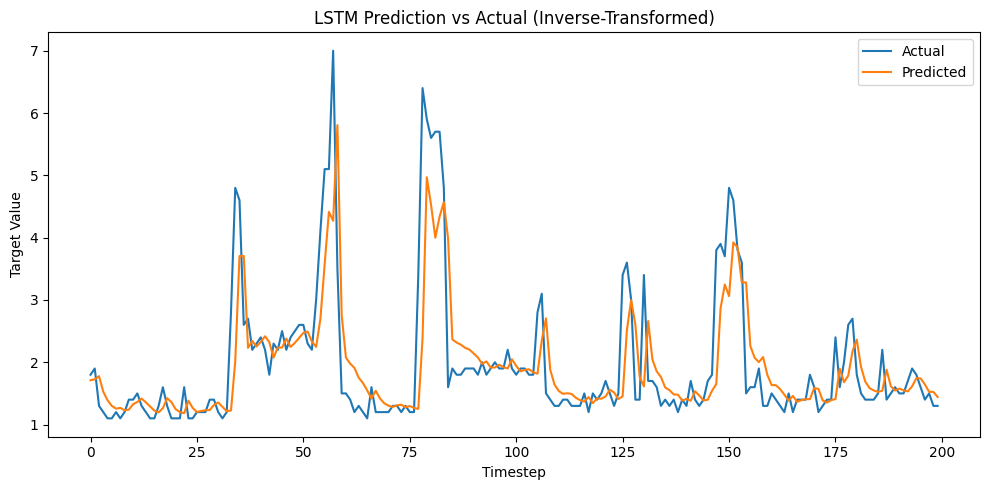

In [24]:

# 테스트셋 분할
split_idx = int(len(X) * 0.8)
X_test = X[split_idx:]
y_test = y[split_idx:]

# Tensor 변환
X_test_tensor = torch.from_numpy(X_test).unsqueeze(-1)  # (batch, seq_len, input_size)

# 모델 로드 및 예측 수행
model = LSTMModel()
# model.load_state_dict(torch.load("models/lstm_model.pth"))
model.load_state_dict(torch.load("models/lstm_best.pth"))
model.eval()

with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy().flatten()

# 역정규화 처리
y_true = inverse_transform(y_test, scaler, column_index=-1)
y_pred_inv = inverse_transform(y_pred, scaler, column_index=-1)

# 성능 평가
# rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_true, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred_inv)

print("LSTM Prediction Evaluation")
print("RMSE:", round(rmse, 5))
print("MAE :", round(mae, 5))

# 예측값 확인 출력
print("y_true[:5] =", y_true[:5].flatten())
print("y_pred_inv[:5] =", y_pred_inv[:5].flatten())
print("std(y_pred) =", np.std(y_pred))
print("std(y_pred_inv) =", np.std(y_pred_inv))

# 시각화 (역정규화 기준)
plt.figure(figsize=(10, 5))
plt.plot(y_true[:200], label='Actual')       # First 200 samples
plt.plot(y_pred_inv[:200], label='Predicted')
plt.title("LSTM Prediction vs Actual (Inverse-Transformed)")
plt.xlabel("Timestep")
plt.ylabel("Target Value")
plt.legend()
plt.tight_layout()
plt.show()